## Homework 3
### Olivia Cooper
### Computational Astrophysics, Spring 2022

In [1]:
# the basics

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import astropy
from astropy.table import Table, SortedArray
import astropy.units as u
import astropy.constants as cns
import rebound
import rebound_utils as reb
plt.style.use('../cooper-paper.mplstyle')

### Problem 1: Let’s not be strangers!

a) Look through the documentation and poke around in the code. Let’s suppose we want to
integrate the orbits for a 3 body system. Draw a flow chart for how the code initializes and
evolves this interaction.

![title](3bodyflow.png)

b) The code offers a variety of different choices of integrators. Make a table of the different
options, list their order of accuracy (if documented), what problems they are best suited for,
and note any tunable parameters.

Integration scheme | Order of accuracy | Problems best suited for | Tunable parameters
 --- | --- | --- | ---
`Gragg-Bulirsch-Stoer` | 2 (modified midpoint) | integrate arbitrary ODEs, for short integrations where only medium accuracy is required|`ri_bs.eps_rel`=sets relative tolerance, `ri_bs.eps_abs`= sets absolute tolerance, `min_dt`, `max_dt` = minimum and maximum timestep
`Embedded Operator Splitting` | 2-8 | planetary motion | `n`=number of sub-timesteps, `phi0`=outer operator splitting scheme, `phi1`= inner operator splitting scheme
`Integrator with Adaptive Step-size control (15)` | 15 | high accuracy orbit integration with non-conservative forces | `epsilon` = adjust adaptive timestepping, `min_dt` = minimum allowed timestep, `epsilon_global` = method of dertermining relative acceleration error
`Janus` | 6 |  broad range, exactly time-reversible |`scale_pos`=scale of problem Positions get divided by this number before the conversion to an integer, `scale_vel`= Velocities get divided by this number before the conversion to an integer, `order`=order of the scheme
`Leap-frog` | 2 | non-rotating coordinate systems | ---
`MERCURIUS` | 7 (arbitrarily high) | planet-planetary collisions, test particles, additional forces |`L`= function pointer to the force switching function, `hillfac`= multiplicative for the Hill radius of particles to determine critical switchover radii, `recalculate_coordinates_this_timestep`=recalculate heliocentric coordinates from the particle structure at the beginning of the next timestep, `recalculate_dcrit_this_timestep`=  recalculate the critical switchover distances dcrit at the beginning of the next timestep, `safe_mode`= If this flag is set to 1 (the default), the integrator will recalculate heliocentric coordinates and synchronize after every timestep to avoid problems with outputs or particle modifications between timesteps
`SABA` | 10 | perturbed Hamiltonian systems, planetary N-body problems |`type`=specifies which SABA integrator type, `safe_mode`=same as in WHFast, `keep_unsynchronized`
`Symplectic Epicycle Integrator` | *machine precision* | epicyclic motion with no perturbing forces | `OMEGA` = epicyclic/orbital frequency, `OMEGAZ`=epicyclic frequency in vertical direction
`WHFast` | 11 | for systems in which there is a dominant central object and perturbations to the Keplerian orbits are small|`unsigned int corrector` = turn on/off diferent first sympletic correctors, `unsigned int corrector2` =  turns on/off second symplectic correctors, `unsigned int kernel` = determines the kernel of the intergrator, `unsigned int coordinate`= set coordinate system

c) Look at the leapfrog and symplectic epicyclic integrator code (see the repository src
“source” directory). Make a flow chart for how these functions work. For production research
you would want to read the method papers for each of the solvers to better understand their
implementations, strengths and weaknesses. Here, this is not necessary unless you want to
dig deeper into how the algorithms work.

#### Leapfrog

1. Initialize loop, set integer $N$ to loop over, call particles and initial conditions, set timestep $dt$

2. For integers $0$ - $N$: 

      (a) Update (drift) positions (for each axis $x,y,z$) by adding $0.5\times dt \times v$ for particle velocity $v$ to the old positions
      
      (b) Update time by adding $dt/2$ to the old time
      
      (c) Update (kick) velocities by adding $dt \times a$ for particle acceleration (force per mass) $a$
      
      (d) Update (drift) positions with new velocities by adding $0.5\times dt \times v$ for particle velocity $v$ to the old positions

#### Symplectic Epicyclic Integrator (SEI)

1. Pre-calculate sin and tan of `OMEGA` (epicyclic/orbital frequency) and `OMEGAZ` (epicyclic frequency in vertical direction) needed for SEI.

2. For integers $0$ - $N$, evolve particle under the unperturbed Hamiltonian as follows:

      (a) Integrate vertical position $zx$ by multiplying $z$ position by `OMEGAZ` and $zy$ by $z$ velocity
      
      (b) Implement rotation using 3 shear operators using `OMEGA` and `OMEGAZ` sin/tan values, then with these rotations, update $z$ position and velocity
      
      (d) Integrate lateral ($x,y$) motion by finding the center of epicyclic motion and applying the epicycle vector
      
      (e) Implement rotation using 3 shear operators using `OMEGA` and `OMEGAZ` sin/tan values, then with these rotations, update $x,y$ positions and velocities
     

### Problem 2: Hello Comets

You may recall seeing articles about the ESA Rosetta mission that visited and then sent
a probe to land on a comet. This was eponymously named 67P/Churyumov–Gerasimenko
comet (see https://en.wikipedia.org/wiki/67P/ChuryumovGerasimenko). There is an
example problem based on this comet, which we will use to get familiar with Rebound.

a) Set up and run the 67P/C-G example problem following the documentation (see Examples
→ Planetary systems → Just getting started → The comet 67P/Churyumov-Gerasimenko).
Only include the Sun, Saturn and Jupiter for now. Include a plot of the 67P/C-G comet
and two planet orbits evolved over 70 years in your solution set.

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')


/opt/anaconda3/lib/python3.8/site-packages/rebound/horizons.py:157: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


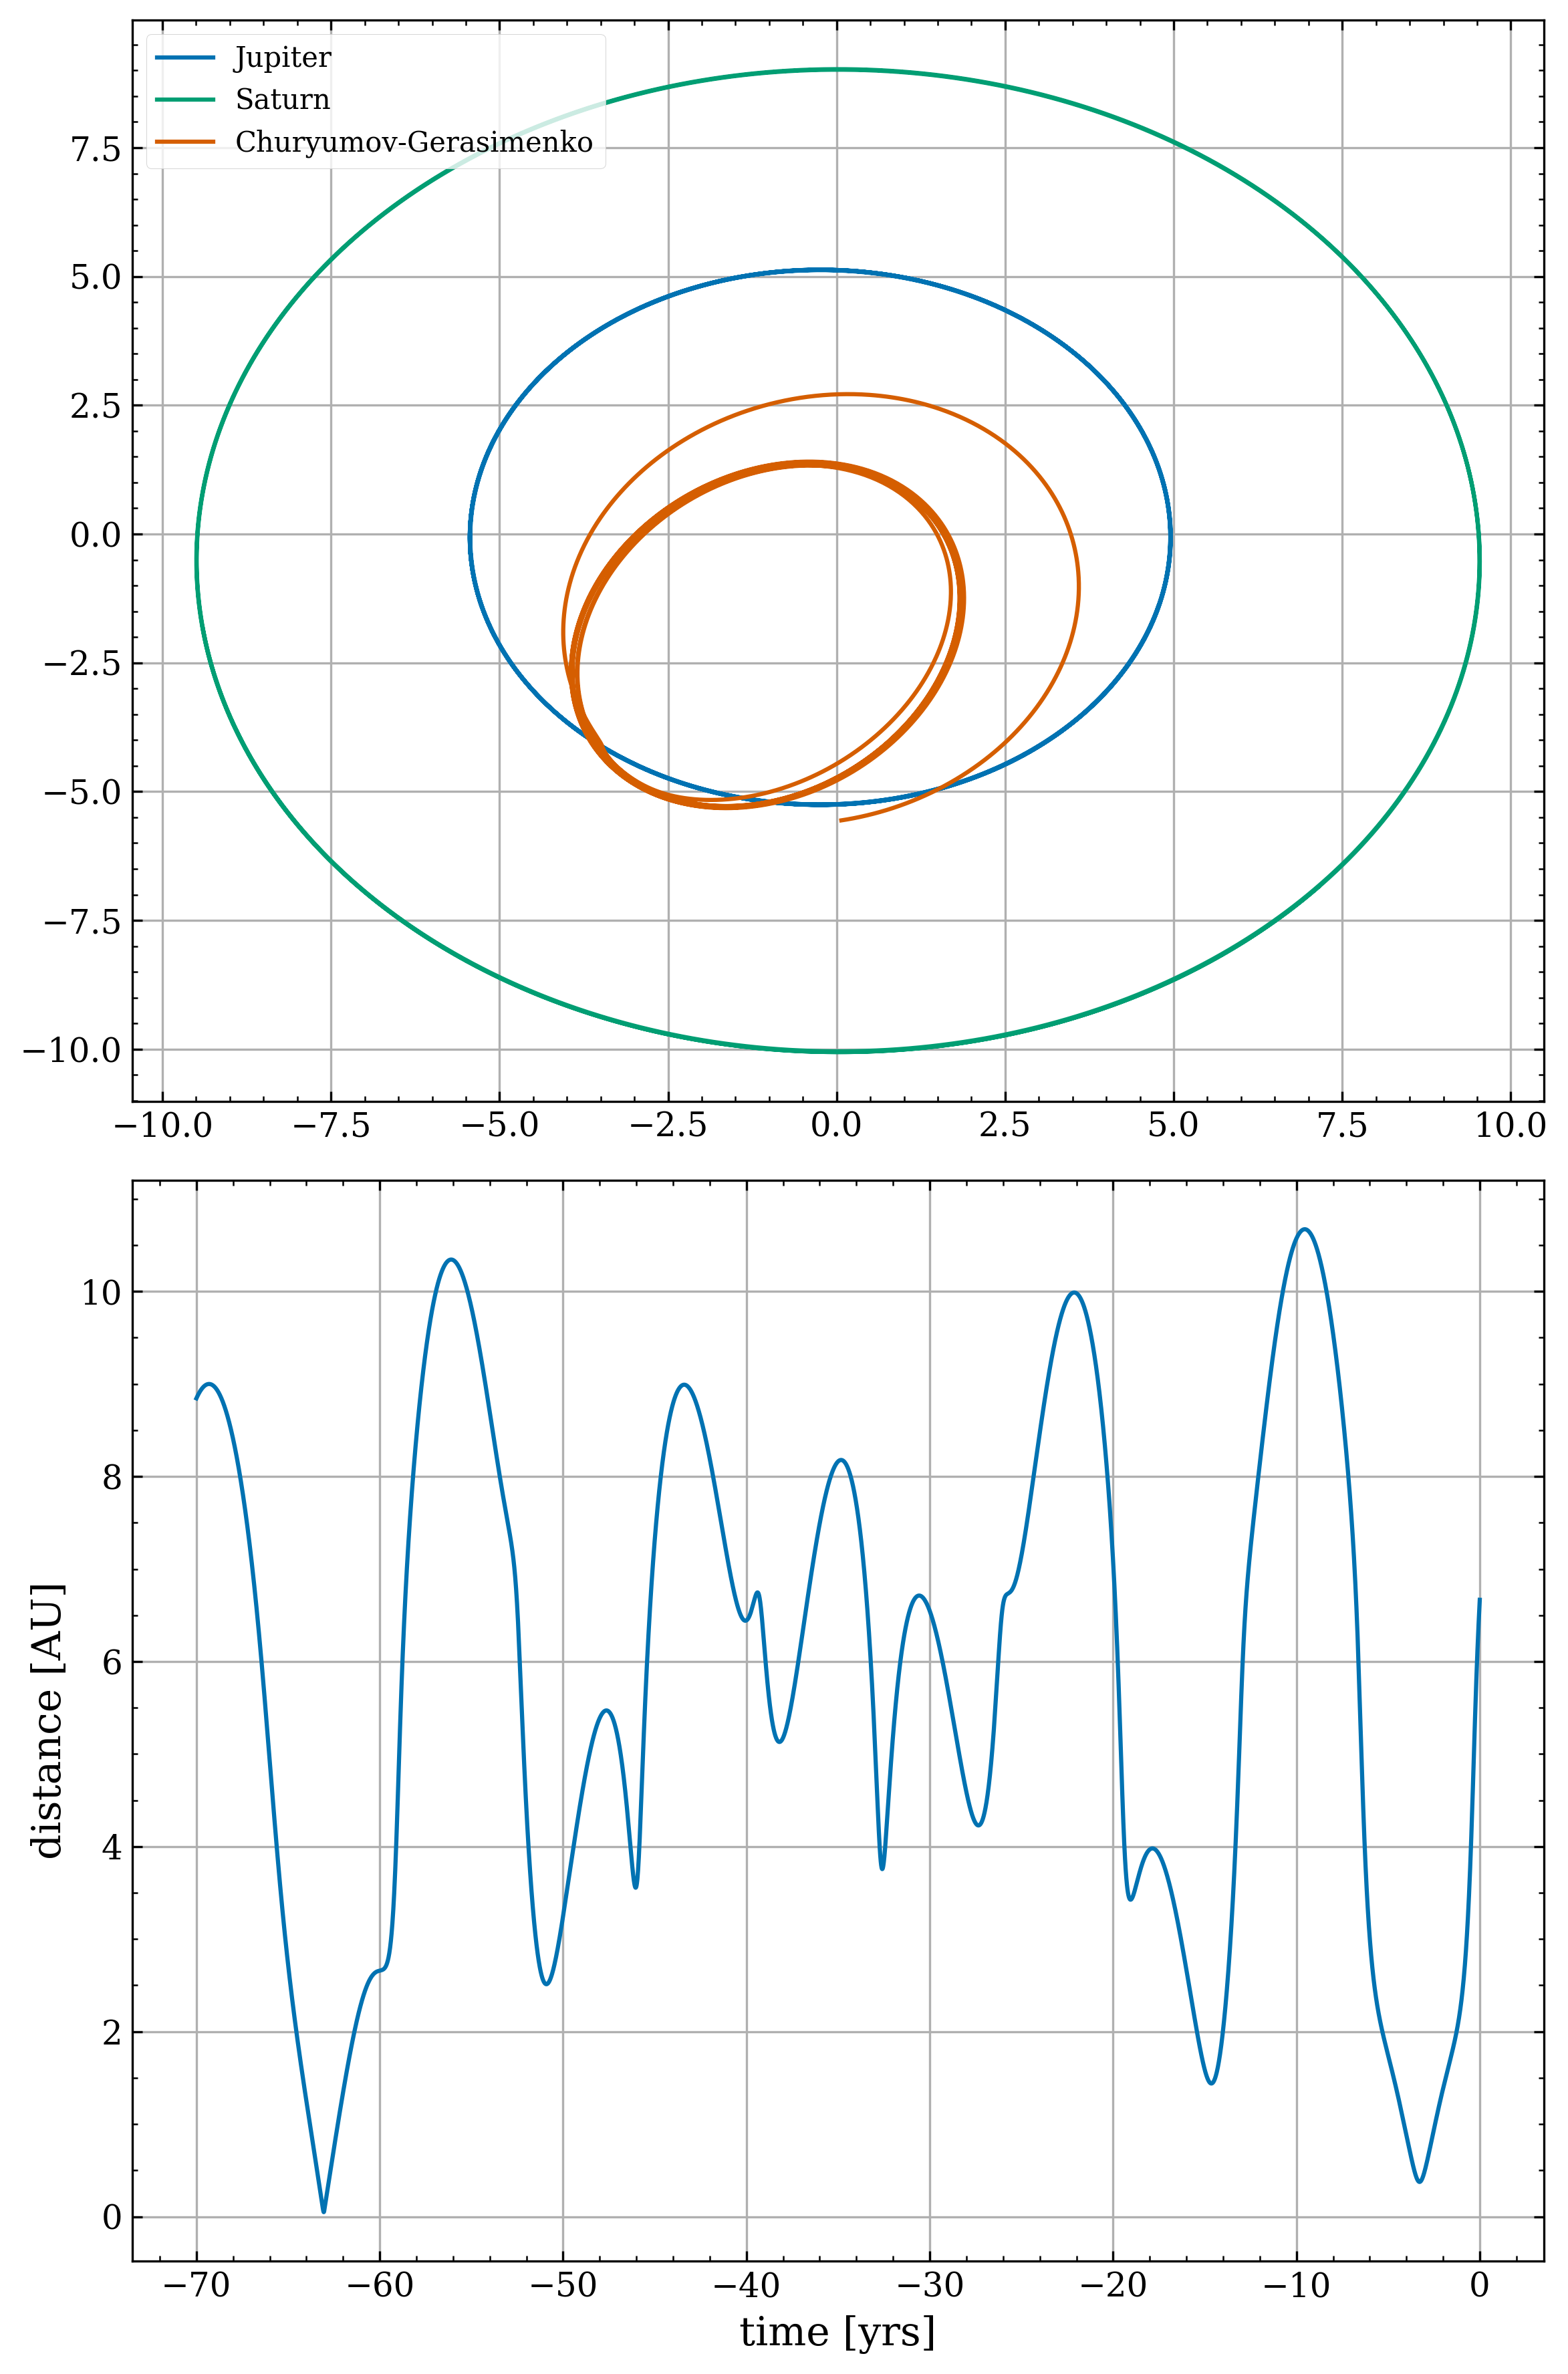

In [2]:
ias_01 = reb.rebound_orbit(intg='ias15',dt=-0.01,plot=True,Noutputs=10000)

b) Experiment with the timestep and integrator choice (e.g., IAS15 vs WHFast). How does
the result change with different integrators? What integrator(s) do you think work best for
this problem? How does the result change as a function of the timestep? E.g., you can evaluate this by looking at energy conservation and the change in orbits. (Note IAS15 has adaptive timestepping so you have to set the minimum timestep.)

In [3]:
ias_01 = reb.rebound_orbit(intg='whfast',dt=-0.01,plot=False,Noutputs=50)
whf_01 = reb.rebound_orbit(intg='whfast',dt=-0.01,plot=False,Noutputs=50)
lf_01 = reb.rebound_orbit(intg='leapfrog',dt=-0.01,plot=False,Noutputs=50)

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')
Searching NASA Horizons for 'Sun'... 


/opt/anaconda3/lib/python3.8/site-packages/rebound/horizons.py:157: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')
Searching NASA Horizons for 'Sun'... 


/opt/anaconda3/lib/python3.8/site-packages/rebound/horizons.py:157: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')


/opt/anaconda3/lib/python3.8/site-packages/rebound/horizons.py:157: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


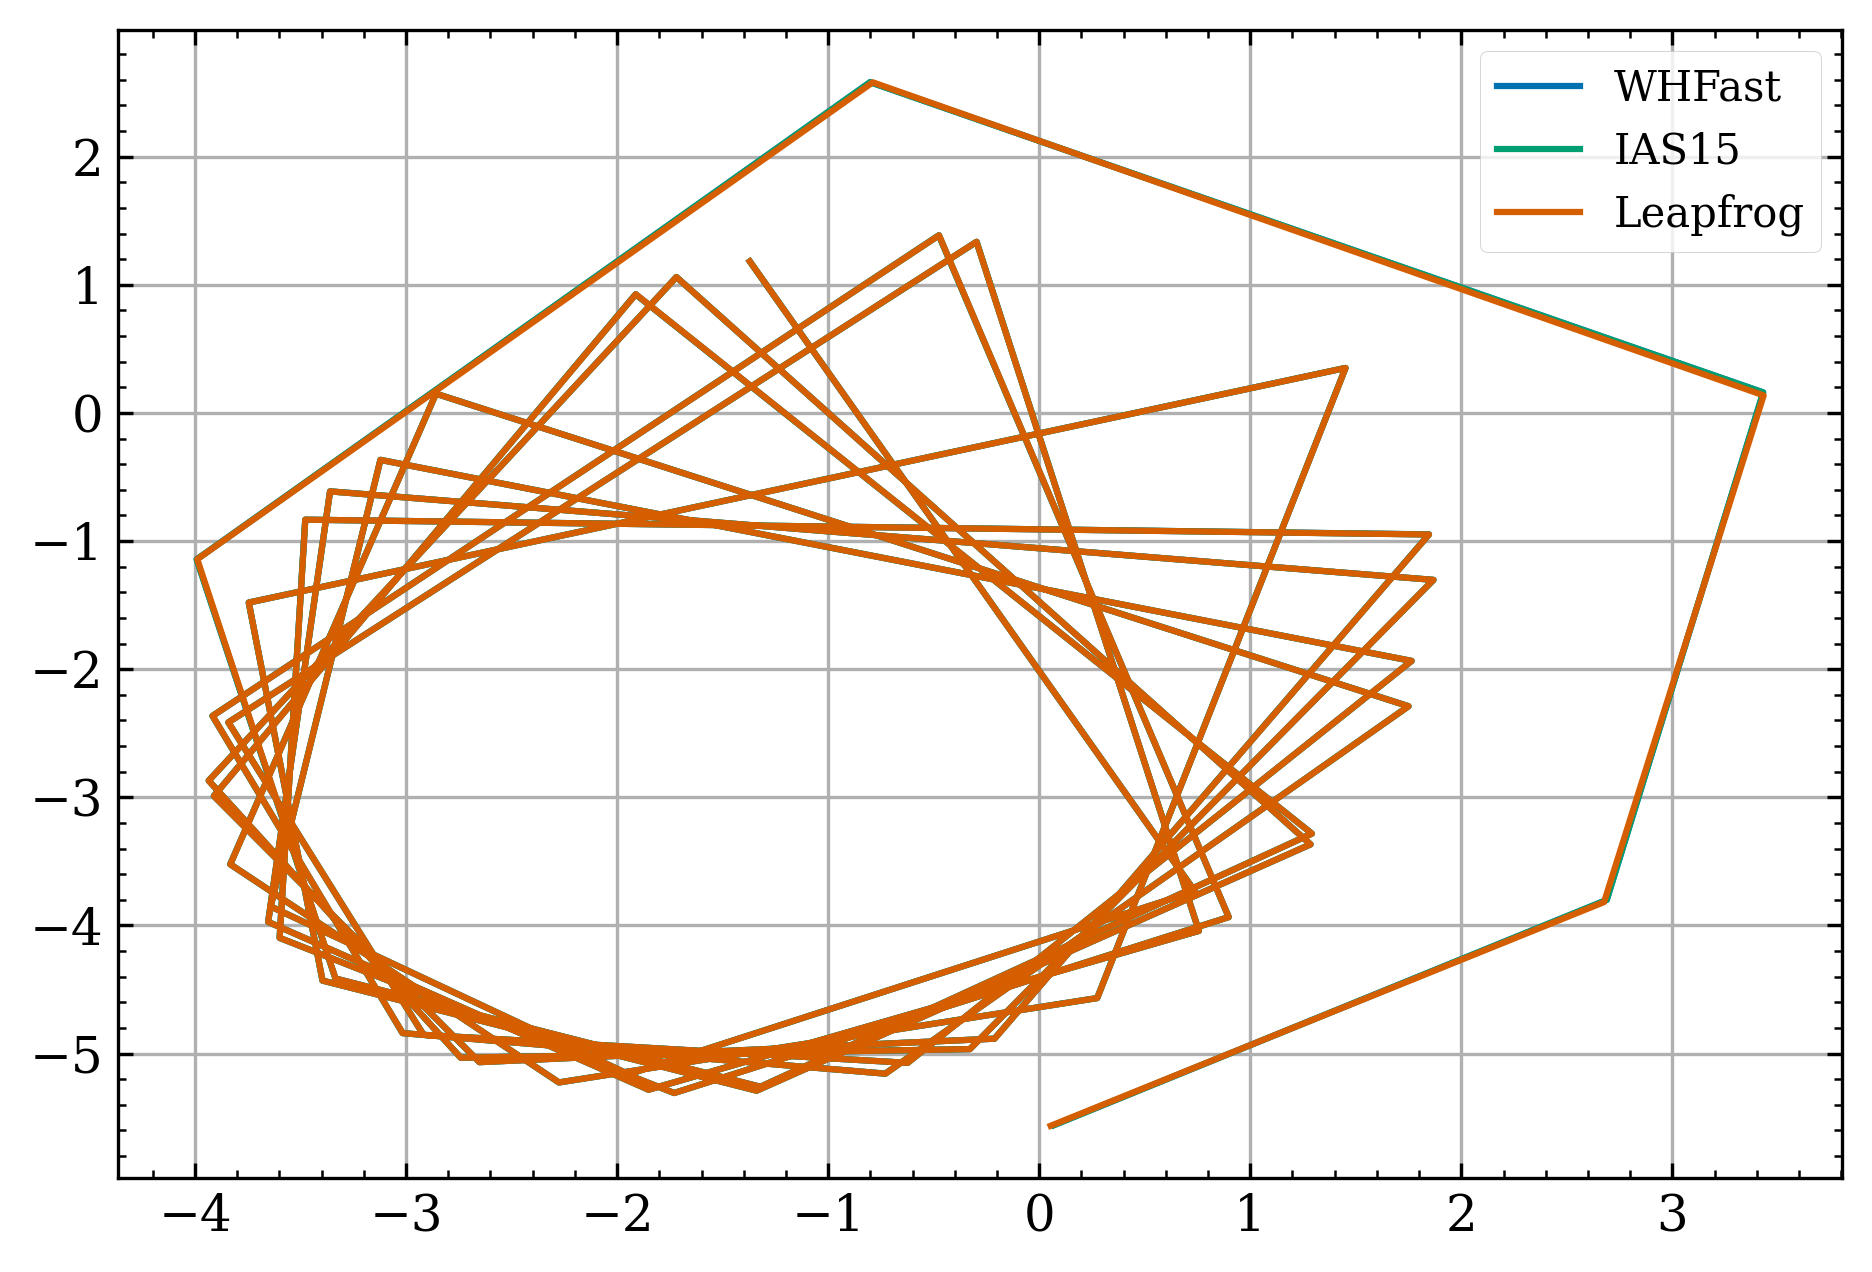

In [4]:
cg = np.where(ias_01['Name']=='Churyumov-Gerasimenko')
plt.plot(whf_01['x'][cg][0],whf_01['y'][cg][0],label='WHFast')
plt.plot(ias_01['x'][cg][0],ias_01['y'][cg][0],label='IAS15')
plt.plot(lf_01['x'][cg][0],lf_01['y'][cg][0],label='Leapfrog')
plt.legend()

In [5]:
ias_1 = reb.rebound_orbit(intg='whfast',dt=-0.1,plot=False,Noutputs=50)
ias_001 = reb.rebound_orbit(intg='whfast',dt=-0.001,plot=False,Noutputs=50)

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')
Searching NASA Horizons for 'Sun'... 


/opt/anaconda3/lib/python3.8/site-packages/rebound/horizons.py:157: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')


/opt/anaconda3/lib/python3.8/site-packages/rebound/horizons.py:157: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


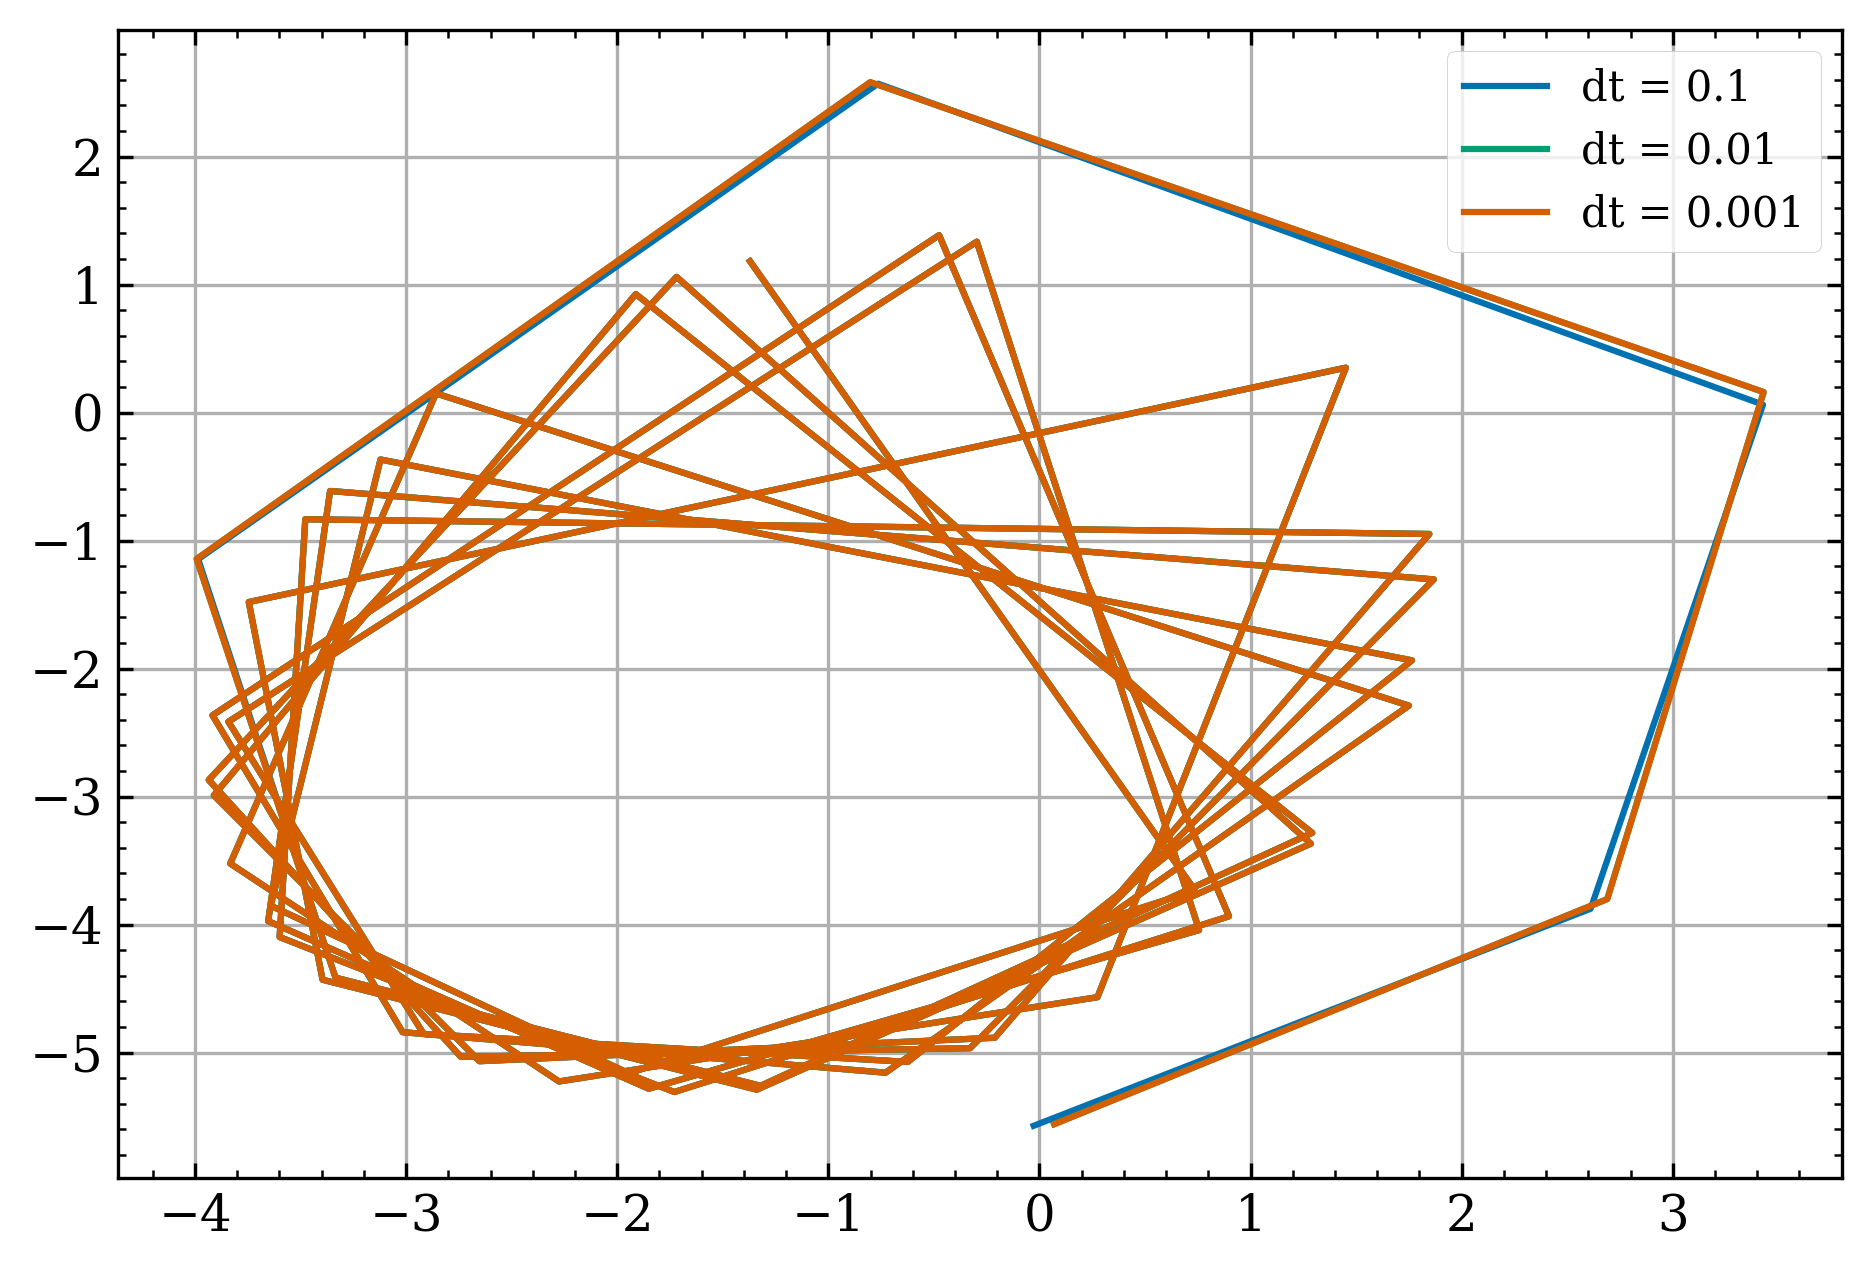

In [6]:
plt.plot(ias_1['x'][cg][0],ias_1['y'][cg][0],label='dt = 0.1')
plt.plot(ias_01['x'][cg][0],ias_01['y'][cg][0],label='dt = 0.01')
plt.plot(ias_001['x'][cg][0],ias_001['y'][cg][0],label='dt = 0.001')
plt.legend()

c) How does the orbit of 67PC-G change when you add the rest of the Solar System planets?
Which is the larger source of error – the parameter choices such as the integrator and/or
timestep or missing bodies?

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Mars'... 
Found: Mars Barycenter (4) (chosen from query 'Mars')
Searching NASA Horizons for 'Earth'... 
Found: Earth-Moon Barycenter (3) (chosen from query 'Earth')
Searching NASA Horizons for 'Venus'... 
Found: Venus Barycenter (299) (chosen from query 'Venus')
Searching NASA Horizons for 'Mercury'... 
Found: Mercury Barycenter (199) (chosen from query 'Mercury')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')
Searching NASA Horizons for 'Churyumov-Gerasimenko'... 
Found: 67P/Churyumov-Gerasimenko (chosen from query 'Churyumov-Gerasimenko')


/opt/anaconda3/lib/python3.8/site-packages/rebound/horizons.py:157: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


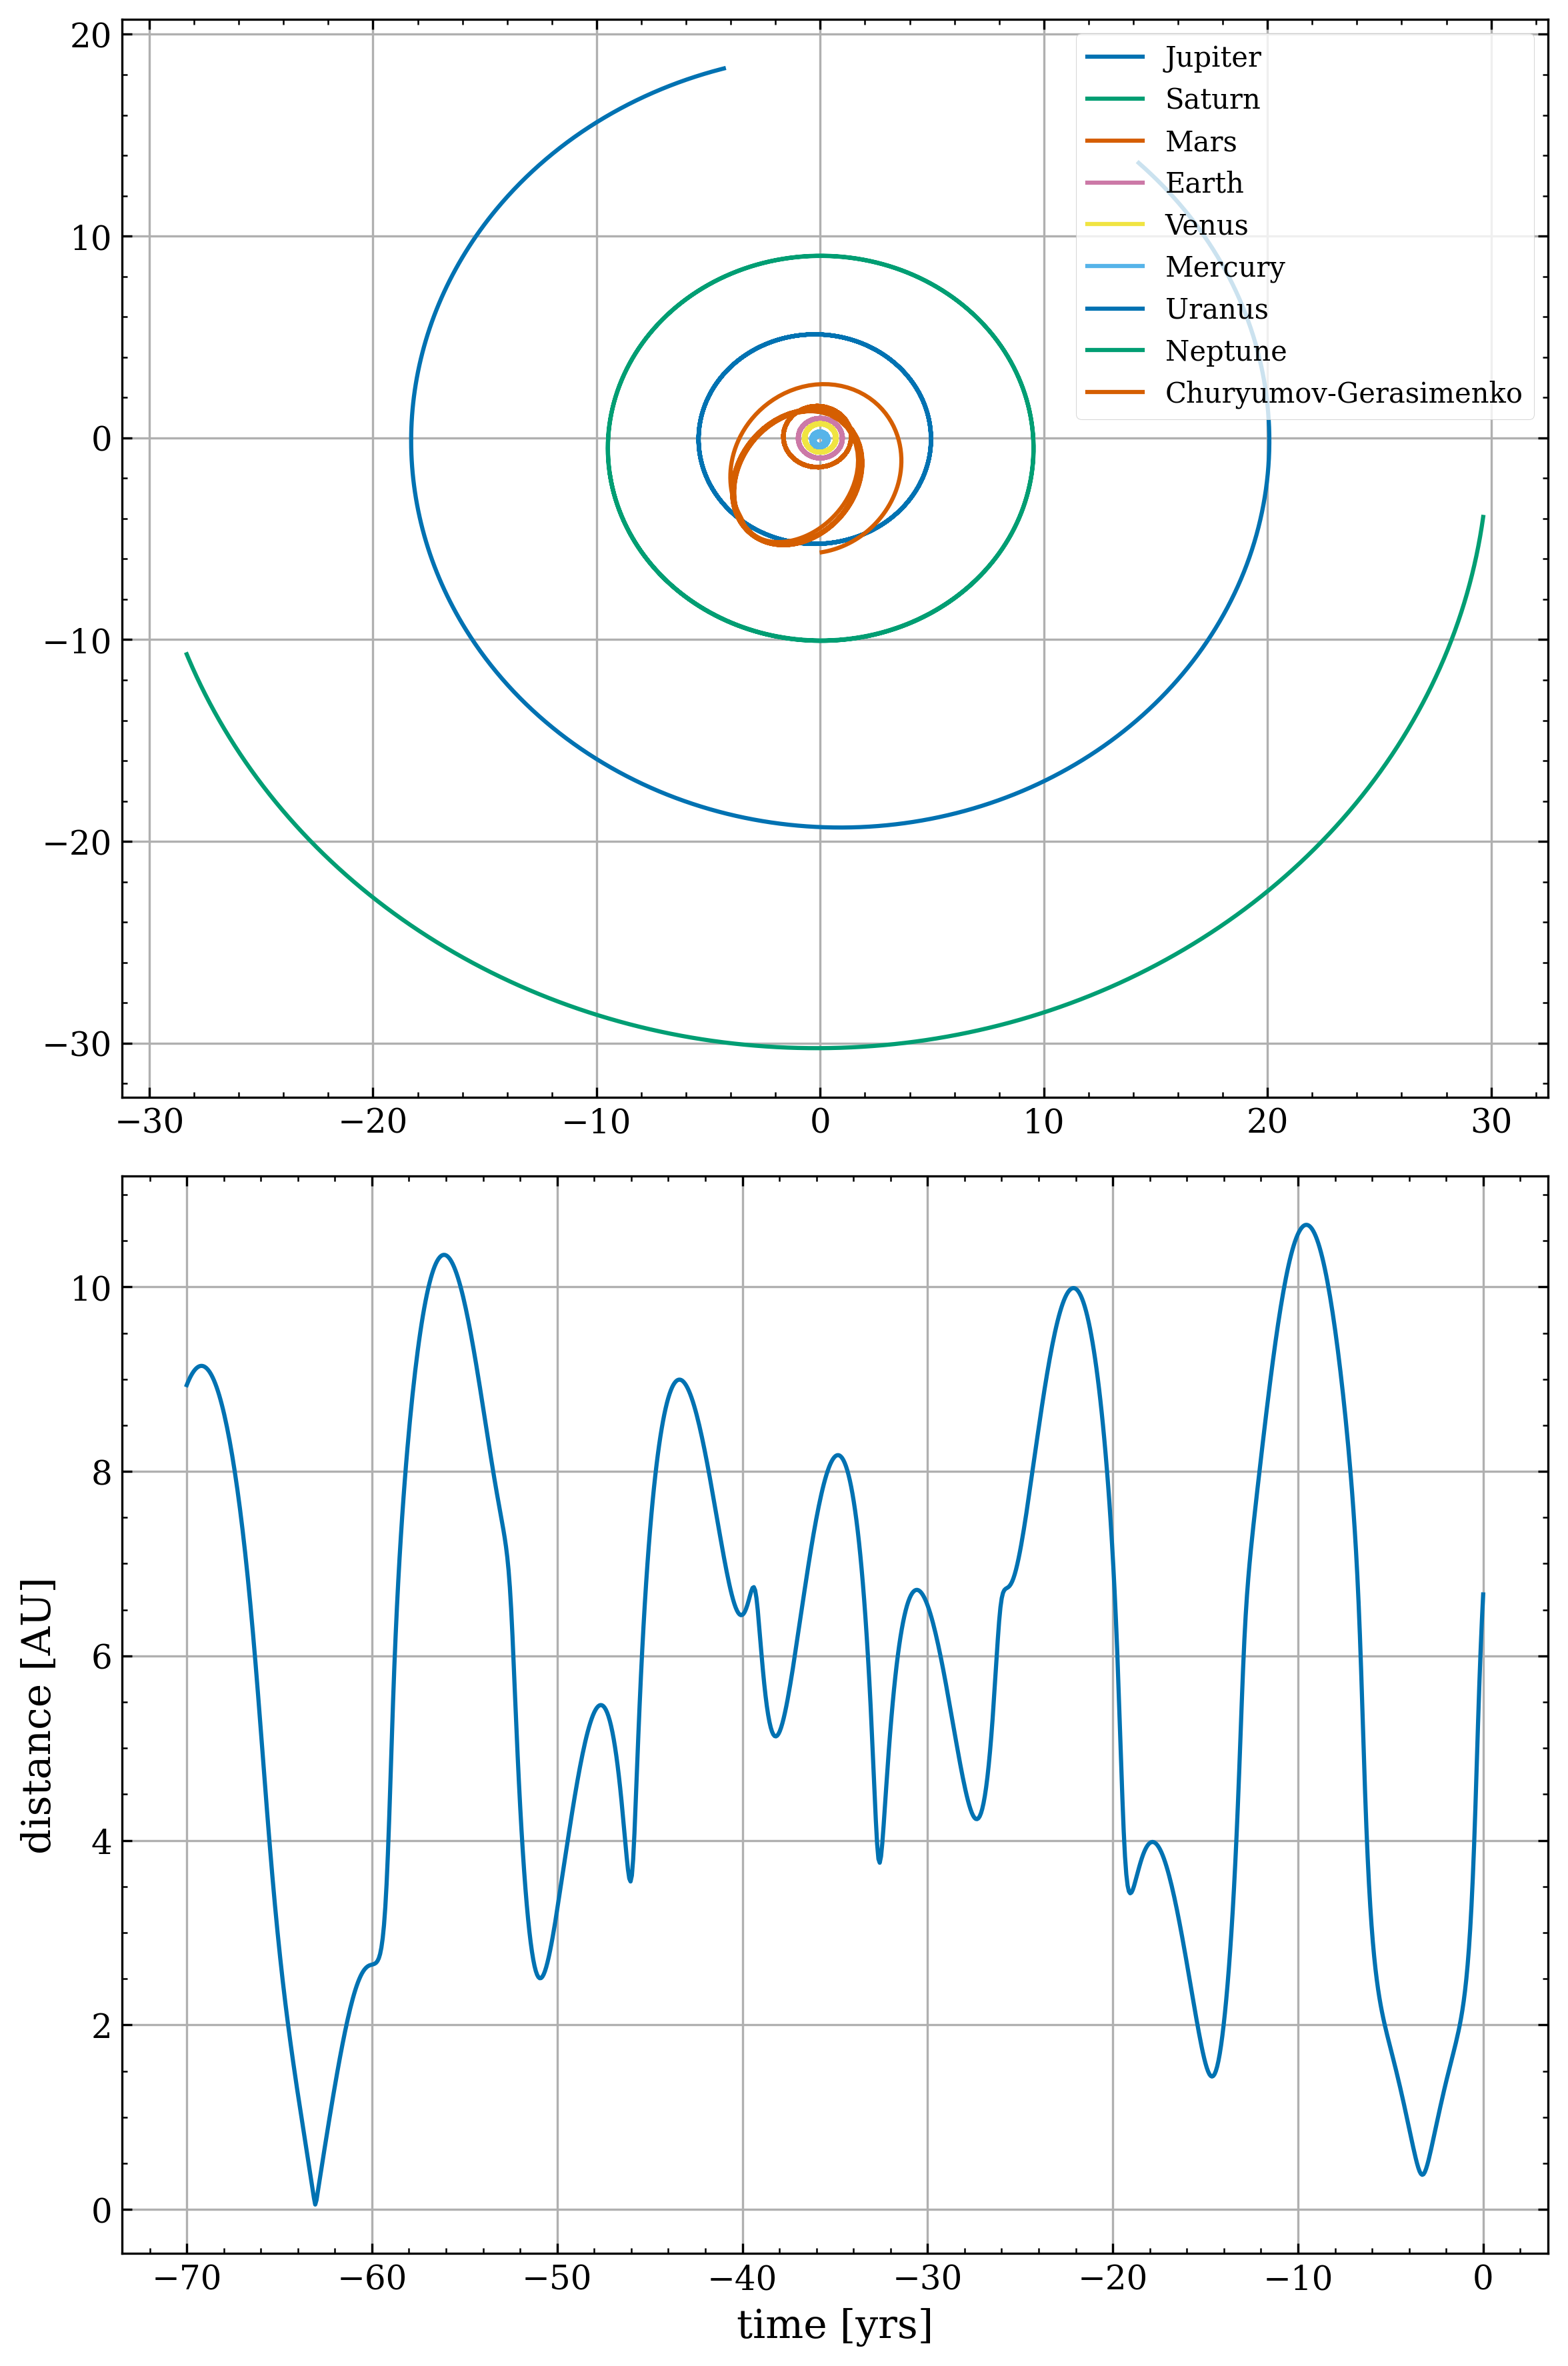

In [7]:
full = reb.rebound_orbit(intg='ias15',dt=0.01,Noutputs=1000,bodies=['Sun','Jupiter','Saturn','Mars','Earth',\
                                                'Venus','Mercury','Uranus','Neptune','Churyumov-Gerasimenko'])

### Problem 3: Finding Planet X (actually Planet Nine)

There is a long history of speculation that another undiscovered planet might exist outside
our Solar system. Originally this planet was known as “Planet X.” A more recent 2016 study
has hypothesized anew about the presence of a large planet beyond the Kuiper belt (now
called “Planet nine”). 

Set up a Solar System with all the planets and Pluto. Suppose Planet Nine has a semi-major
axis of 460 au and eccentricity of 0.4. How massive would it need to be to perturb Pluto’s
orbit by 10% after 10 years of evolution? Given your answer, why do you think we haven’t
found any Planet Nine yet?

In [8]:
# set up the simulation 
bodies=['Sun','Jupiter','Saturn','Mars','Earth',\
          'Venus','Mercury','Uranus','Neptune','Pluto','Planet Nine'] # define objects
sim = rebound.Simulation(); sim9 = rebound.Simulation() # set up solar system sim and solar system sim plus planet 9
sim.add(bodies[:-1]); sim9.add(bodies[:-1]) # add in solar system plus pluto to both

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Mars'... 
Found: Mars Barycenter (4) (chosen from query 'Mars')
Searching NASA Horizons for 'Earth'... 
Found: Earth-Moon Barycenter (3) (chosen from query 'Earth')
Searching NASA Horizons for 'Venus'... 
Found: Venus Barycenter (299) (chosen from query 'Venus')
Searching NASA Horizons for 'Mercury'... 
Found: Mercury Barycenter (199) (chosen from query 'Mercury')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')
Searching NASA Horizons for 'Pluto'... 
Found: Pluto Barycenter (9) (chosen from query 'Pluto')
Searching NASA Horizons for 'Sun'... 
Found: Sun (1

In [9]:
# run sim without planet 9
sim.dt = 0.001
nb = len(bodies)
Noutputs = 10000 # number of times to calculate position
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,10.*year, Noutputs) # time array
x = np.zeros((nb,Noutputs))
y = np.zeros((nb,Noutputs))
z = np.zeros((nb,Noutputs))

sim.move_to_com()        # We always move to the center of momentum frame before an integration
ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

for i,time in enumerate(times):
    sim.integrate(time)
    for j in range(nb-1):
        x[j][i] = ps[j].x
        y[j][i] = ps[j].y
        z[j][i] = ps[j].z

logmass =  -5.0
logmass =  -4.8
logmass =  -4.6
logmass =  -4.3999999999999995
logmass =  -4.199999999999999
logmass =  -3.999999999999999


/opt/anaconda3/lib/python3.8/site-packages/rebound/simulation.py:712: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


logmass =  -3.799999999999999


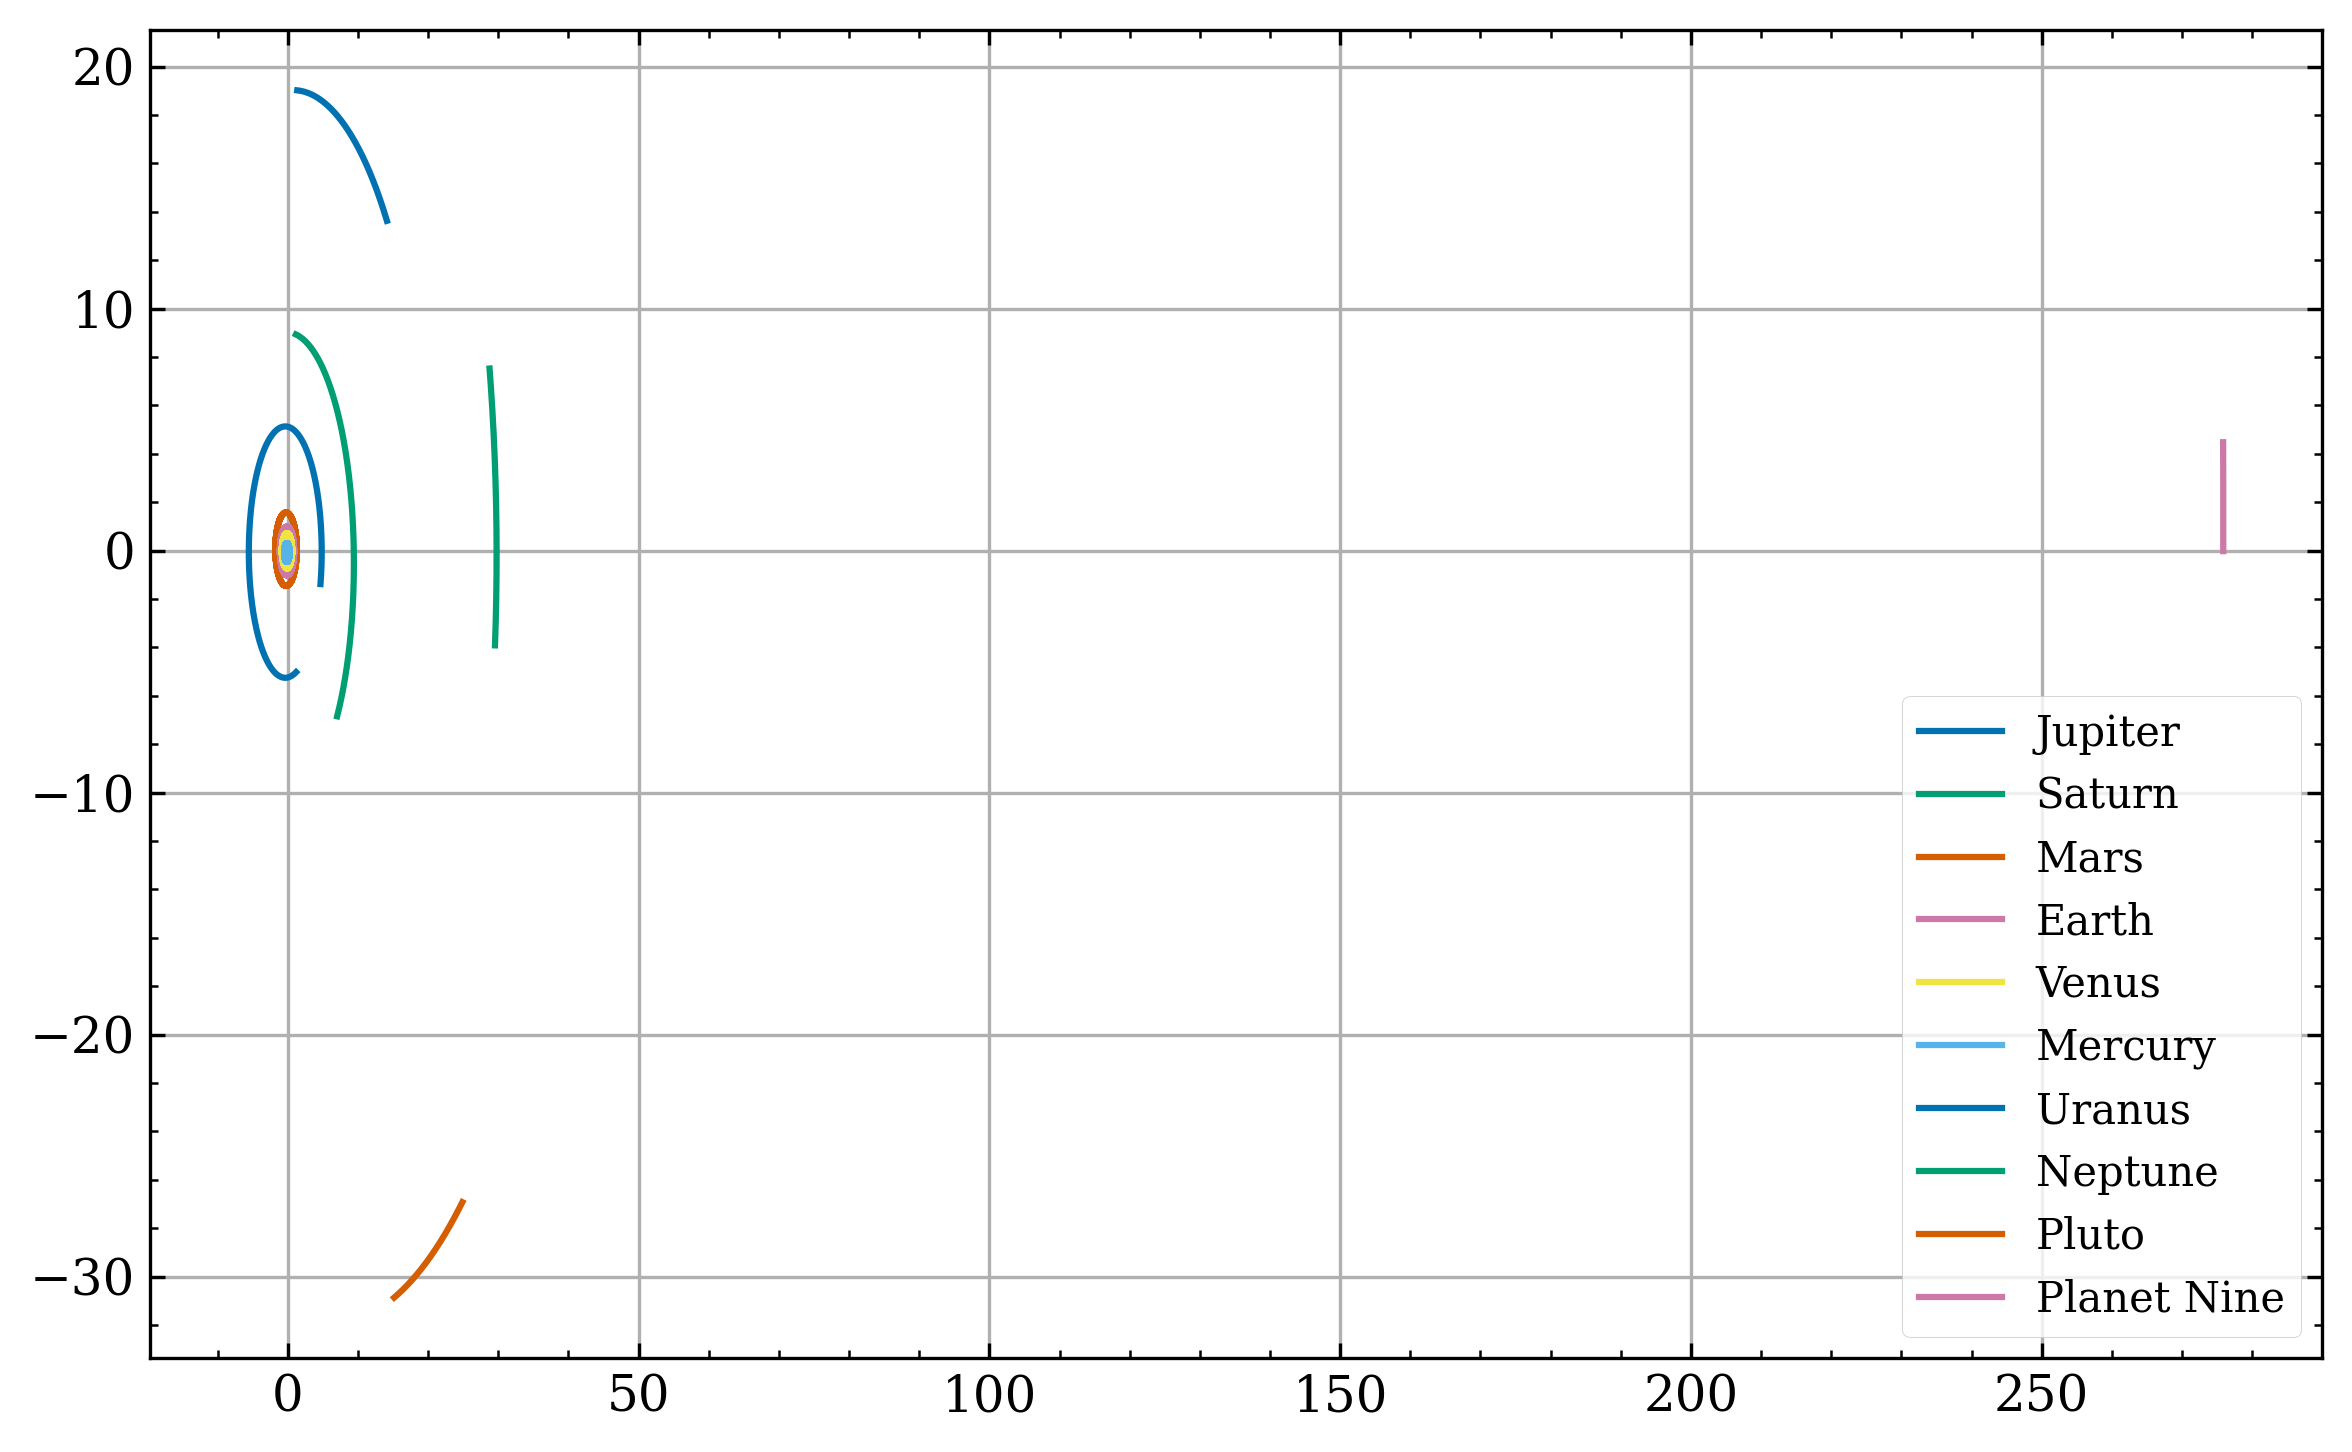

In [10]:
# run sim with planet 9
logmass = -5. # define initial log10(mass) of planet 9
dlogm = 0.2 # define log10(dm) to increase mass by each round
frac_err = 0. # initialize fractional error

# while loop to increase planet 9 mass until frac error exceeds 10%
while frac_err < 0.1: 
    
    # planet 9
    sim9.add(m=10**logmass,a=460,e=0.4)
    print('logmass = ',logmass)
    # set up integration params
    sim9.dt = sim.dt
    x9 = np.zeros((nb,Noutputs))
    y9 = np.zeros((nb,Noutputs))
    z9 = np.zeros((nb,Noutputs))

    sim9.move_to_com()         # We always move to the center of momentum frame before an integration
    ps9 = sim9.particles       # ps is now an array of pointers and will change as the simulation runs

    for i,time in enumerate(times):
        sim9.integrate(time)
        for j in range(nb):    
            x9[j][i] = ps9[j].x
            y9[j][i] = ps9[j].y
            z9[j][i] = ps9[j].z
    frac_err = np.max(0.5 * (2*(x[-2]-x9[-2]) + 2*(y[-2]-y9[-2]) + (2*(z[-2]-z9[-2]))))
    logmass += dlogm

        
# plot orbits 
fig = plt.figure(figsize=(8,5))
for j in range(nb):
    if j == 0:
        pass
    else:
        plt.plot(x9[j], y9[j], label=bodies[j])   
plt.legend()

In [11]:
print(frac_err, logmass)
print('The mass of Planet 9 would have to be about 10^',np.round(logmass,3),'solar masses to perturb Pluto by >10% over 10 years')

0.1136750934492401 -3.5999999999999988
The mass of Planet 9 would have to be about 10^ -3.6 solar masses to perturb Pluto by >10% over 10 years


This means Planet 9 would have to be about 100 times more massive than Jupiter to perturb Pluto's orbit by over 10% in 10 years. That's quite massive and getting into star territory, so it's pretty unlikely we wouldn't see it with other methods before detecting any orbital perturbations.